## Step 1: Importing Required Libraries
This cell imports the necessary libraries for data handling, image processing, model building, and visualization.


In [ ]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.19.0


### Step 1.1: Mounting Google Drive
Mounting Google Drive to access the dataset and save outputs like trained models.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile

ZIP_PATH = "/content/drive/MyDrive/Colab_Datasets/plantvillage.zip"
EXTRACT_DIR = "/content/PlantVillage"

# Extract dataset if not extracted
if not os.path.exists(EXTRACT_DIR):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
else:
    print("Dataset already extracted.")

# Update your dataset path (folder containing class subfolders)
DATA_DIR = "/content/PlantVillage/newplantvillage"

OUTPUT_DIR = "/content/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Dataset available at:", DATA_DIR)


Mounted at /content/drive
Extracting dataset...
Dataset available at: /content/PlantVillage/newplantvillage


## Step 2: Dataset Path Configuration
Here we define the paths for the dataset and prepare the directories needed for training, validation, and testing.


In [ ]:
CONFIG = {
    "DATASET_DIR": DATA_DIR,
    "IMG_SIZE": (224, 224),
    "BATCH_SIZE": 32,
    "EPOCHS": 15,
    "SEED": 42,
    "TRAIN_SPLIT": 0.8,
    "VAL_SPLIT": 0.1,
    "TEST_SPLIT": 0.1,
    "MODEL_SAVE_PATH": "/content/output/anna_efficientnetb0.h5",
    "AUTOTUNE": tf.data.AUTOTUNE
}


## Step 3: Train–Validation–Test Split
This cell checks if the dataset is already split.  
If not, it automatically creates properly organized `train`, `val`, and `test` folders.


In [ ]:
def ensure_splitted_dataset(src_dir, target_root,
                            train_frac=0.8, val_frac=0.1, test_frac=0.1, seed=42):

    src = Path(src_dir)
    target_root = Path(target_root)

    if (target_root/"train").exists():
        print("Dataset already split.")
        return (str(target_root/"train"),
                str(target_root/"val"),
                str(target_root/"test"))

    classes = [d.name for d in src.iterdir() if d.is_dir()]
    print("Classes:", classes)

    # Create split directories
    for split in ("train", "val", "test"):
        for c in classes:
            (target_root/split/c).mkdir(parents=True, exist_ok=True)

    # Copy files into splits
    for c in classes:
        files = list((src/c).glob("*.*"))
        train_files, temp = train_test_split(files, train_size=train_frac, random_state=seed)

        val_part = val_frac / (val_frac + test_frac)
        val_files, test_files = train_test_split(temp, train_size=val_part, random_state=seed)

        for f in train_files:
            f.replace(target_root/"train"/c/f.name)
        for f in val_files:
            f.replace(target_root/"val"/c/f.name)
        for f in test_files:
            f.replace(target_root/"test"/c/f.name)

    return str(target_root/"train"), str(target_root/"val"), str(target_root/"test")


In [ ]:
split_root = "/content/PlantVillage_split"

train_dir, val_dir, test_dir = ensure_splitted_dataset(
    CONFIG["DATASET_DIR"],
    split_root,
    CONFIG["TRAIN_SPLIT"],
    CONFIG["VAL_SPLIT"],
    CONFIG["TEST_SPLIT"],
    CONFIG["SEED"]
)

train_dir, val_dir, test_dir


Classes: ['Apple___Cedar_apple_rust', 'Potato___Late_blight', 'Soybean___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Potato___healthy', 'Strawberry___healthy', 'Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot', 'Apple___Black_rot', 'Peach___healthy', 'Raspberry___healthy', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Blueberry___healthy', 'Pepper,_bell___Bacterial_spot', 'Tomato___Bacterial_spot', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Leaf_Mold', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Cherry_(including_sour)___healthy', 'Tomato___Tomato_mosaic_virus', 'Strawberry___Leaf_scorch', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Peach___Bacterial_spot', 'Grape___healthy', 'Potato___Early_blight', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Apple___healthy', 'Pepper,_bell___healthy', 'Apple___Apple_scab', 'Tomato___healthy', 'Squash___Powdery_mildew']


('/content/PlantVillage_split/train',
 '/content/PlantVillage_split/val',
 '/content/PlantVillage_split/test')

### Step 3.1: Class Distribution

,Split,Class,Count
0,train,Apple___Cedar_apple_rust,1408
1,train,Potato___Late_blight,1551
2,train,Soybean___healthy,1617
3,train,Cherry_(including_sour)___Powdery_mildew,1346
4,train,Potato___healthy,1459
...,...,...,...
97,test,Apple___healthy,201
98,test,"Pepper,_bell___healthy",199
99,test,Apple___Apple_scab,202
100,test,Tomato___healthy,193


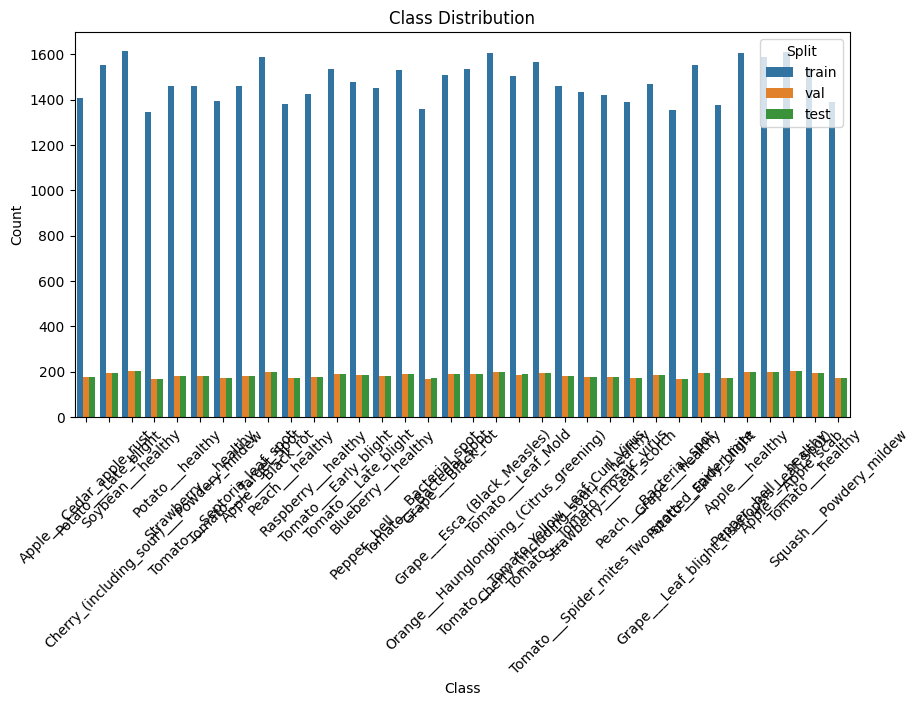

In [ ]:
def plot_class_distribution(root):
    data = []

    for split in ("train", "val", "test"):
        split_path = Path(root)/split
        for cls in split_path.iterdir():
            count = len(list(cls.glob("*.*")))
            data.append([split, cls.name, count])

    df = pd.DataFrame(data, columns=["Split", "Class", "Count"])
    display(df)

    plt.figure(figsize=(10,5))
    sns.barplot(data=df, x="Class", y="Count", hue="Split")
    plt.xticks(rotation=45)
    plt.title("Class Distribution")
    plt.show()

plot_class_distribution(split_root)


## Step 4: Data Preprocessing
This step applies preprocessing such as resizing, normalization, augmentation and converts the images into TensorFlow datasets.


In [ ]:
def make_datasets(train_dir, val_dir, test_dir):
    train_ds = keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=CONFIG["IMG_SIZE"], batch_size=CONFIG["BATCH_SIZE"],
        seed=CONFIG["SEED"], shuffle=True
    )
    val_ds = keras.preprocessing.image_dataset_from_directory(
        val_dir, image_size=CONFIG["IMG_SIZE"], batch_size=CONFIG["BATCH_SIZE"]
    )
    test_ds = keras.preprocessing.image_dataset_from_directory(
        test_dir, image_size=CONFIG["IMG_SIZE"], batch_size=CONFIG["BATCH_SIZE"]
    )

    class_names = train_ds.class_names
    print("Classes:", class_names)

    return (
        train_ds.prefetch(CONFIG["AUTOTUNE"]),
        val_ds.prefetch(CONFIG["AUTOTUNE"]),
        test_ds.prefetch(CONFIG["AUTOTUNE"]),
        class_names
    )

train_ds, val_ds, test_ds, class_names = make_datasets(train_dir, val_dir, test_dir)


Found 50368 files belonging to 34 classes.
Found 6298 files belonging to 34 classes.
Found 6313 files belonging to 34 classes.
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato__

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05)
])


## Step 5: Building the CNN Model
This cell defines the Convolutional Neural Network architecture used for leaf disease classification.


In [ ]:
def build_model(num_classes):
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(*CONFIG["IMG_SIZE"], 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(*CONFIG["IMG_SIZE"], 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model(len(class_names))
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │        43,554 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,093,125 (15.61 MB)

 Trainable params: 43,554 (170.13 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Step 7: Training the Model
Training the CNN model using the prepared dataset.  
This step outputs accuracy, loss, and validation performance across epochs.


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(CONFIG["MODEL_SAVE_PATH"], save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["EPOCHS"],
    callbacks=callbacks
)


Epoch 1/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9625 - loss: 0.1185

1574/1574 ━━━━━━━━━━━━━━━━━━━━ 154s 98ms/step - accuracy: 0.9625 - loss: 0.1185 - val_accuracy: 0.9621 - val_loss: 0.1167 - learning_rate: 5.0000e-04
Epoch 2/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9599 - loss: 0.1185

1574/1574 ━━━━━━━━━━━━━━━━━━━━ 185s 87ms/step - accuracy: 0.9599 - loss: 0.1185 - val_accuracy: 0.9606 - val_loss: 0.1142 - learning_rate: 5.0000e-04
Epoch 3/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 142s 87ms/step - accuracy: 0.9600 - loss: 0.1161 - val_accuracy: 0.9651 - val_loss: 0.1152 - learning_rate: 5.0000e-04
Epoch 4/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.9619 - loss: 0.1131 - val_accuracy: 0.9597 - val_loss: 0.1223 - learning_rate: 5.0000e-04
Epoch 5/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.9621 - loss: 0.1117 - val_accuracy: 0.9616 - val_loss: 0.1144 - learning_rate: 5.0000e-04
Epoch 6/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9641 - loss: 0.1107

1574/1574 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.9641 - loss: 0.1107 - val_accuracy: 0.9655 - val_loss: 0.1078 - learning_rate: 2.5000e-04
Epoch 7/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9659 - loss: 0.1078

1574/1574 ━━━━━━━━━━━━━━━━━━━━ 138s 87ms/step - accuracy: 0.9659 - loss: 0.1078 - val_accuracy: 0.9657 - val_loss: 0.1072 - learning_rate: 2.5000e-04
Epoch 8/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9628 - loss: 0.1103

1574/1574 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.9628 - loss: 0.1103 - val_accuracy: 0.9663 - val_loss: 0.1063 - learning_rate: 2.5000e-04
Epoch 9/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 139s 88ms/step - accuracy: 0.9656 - loss: 0.1081 - val_accuracy: 0.9651 - val_loss: 0.1089 - learning_rate: 2.5000e-04
Epoch 10/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 145s 92ms/step - accuracy: 0.9632 - loss: 0.1087 - val_accuracy: 0.9654 - val_loss: 0.1075 - learning_rate: 2.5000e-04
Epoch 11/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 139s 88ms/step - accuracy: 0.9639 - loss: 0.1088 - val_accuracy: 0.9649 - val_loss: 0.1068 - learning_rate: 2.5000e-04
Epoch 12/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9648 - loss: 0.1062

1574/1574 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.9648 - loss: 0.1062 - val_accuracy: 0.9671 - val_loss: 0.1035 - learning_rate: 1.2500e-04
Epoch 13/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 139s 88ms/step - accuracy: 0.9659 - loss: 0.1058 - val_accuracy: 0.9662 - val_loss: 0.1048 - learning_rate: 1.2500e-04
Epoch 14/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9645 - loss: 0.1044

1574/1574 ━━━━━━━━━━━━━━━━━━━━ 143s 89ms/step - accuracy: 0.9645 - loss: 0.1044 - val_accuracy: 0.9673 - val_loss: 0.1034 - learning_rate: 1.2500e-04
Epoch 15/15
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 141s 88ms/step - accuracy: 0.9638 - loss: 0.1069 - val_accuracy: 0.9668 - val_loss: 0.1037 - learning_rate: 1.2500e-04


## Step 8: Visualizing Training Performance
Plotting accuracy and loss curves to evaluate how the model learned over time.


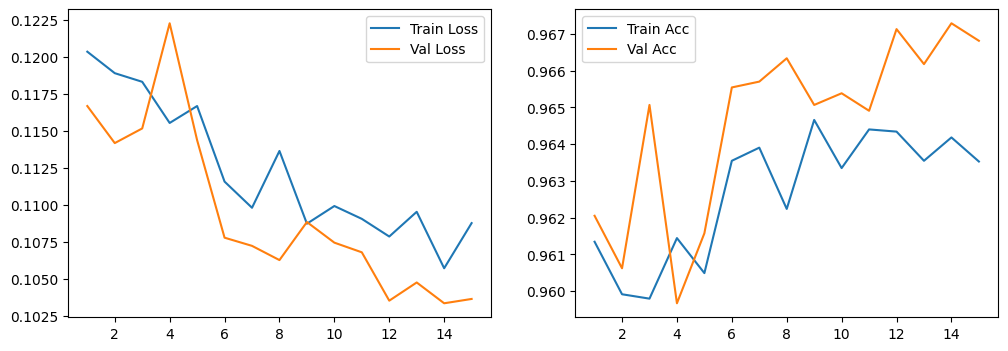

In [ ]:
def plot_history(history):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, hist["loss"], label="Train Loss")
    plt.plot(epochs, hist["val_loss"], label="Val Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist["accuracy"], label="Train Acc")
    plt.plot(epochs, hist["val_accuracy"], label="Val Acc")
    plt.legend()

    plt.show()

plot_history(history)


## Step 9: Model Evaluation on Test Set
Evaluating the trained model on unseen data to measure its real-world performance.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

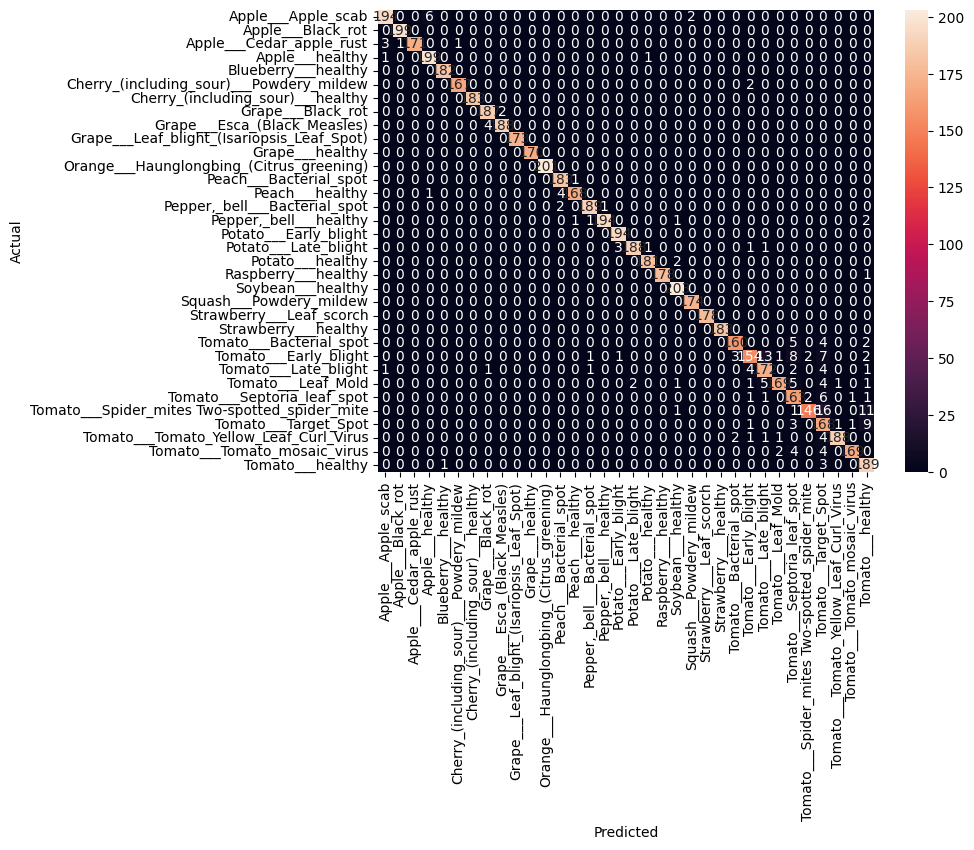

In [ ]:
def evaluate_model(model, test_ds, class_names):
    y_true, y_pred = [], []

    for images, labels in test_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    print("Classification Report")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(model, test_ds, class_names)


## GRAD-CAM

In [ ]:
def gradcam(model, img_path, layer_name="top_conv"):
    import cv2
    from tensorflow.keras.preprocessing import image

    img = image.load_img(img_path, target_size=CONFIG["IMG_SIZE"])
    img_array = image.img_to_array(img)
    img_expanded = np.expand_dims(img_array, axis=0)

    img_pre = tf.keras.applications.efficientnet.preprocess_input(img_expanded)

    grad_model = keras.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_pre)
        pred_class = tf.argmax(predictions[0])
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_output)[0]
    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = np.dot(conv_output[0], weights.numpy())

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_array.shape[1], img_array.shape[0]))
    cam = cam / cam.max()

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    output = heatmap * 0.4 + img_array

    plt.imshow(np.uint8(output))
    plt.axis("off")
    plt.show()


## Step 10: Predicting on a New Image (Result + Confidence)
This cell loads a custom image, preprocesses it for the model, generates a prediction, and displays both the predicted class and the confidence score in a clean, readable format.


In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf
import io
import os

# Upload file
uploaded = files.upload()

if not uploaded:
    print("No file uploaded.")
else:
    filename = next(iter(uploaded))
    print("Uploaded:", filename)

    # Load image
    img = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")

    # Resize to model input size
    IMG_SIZE = CONFIG["IMG_SIZE"]
    img_resized = img.resize(IMG_SIZE)

    # Convert to array
    img_array = np.array(img_resized).astype("float32")
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess for EfficientNet
    img_preprocessed = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Load model if not already loaded
    if "model" not in globals():
        model_path = CONFIG["MODEL_SAVE_PATH"]
        print("Loading model from:", model_path)
        model = tf.keras.models.load_model(model_path)

    # Predict
    preds = model.predict(img_preprocessed)

    pred_idx = int(np.argmax(preds[0]))
    pred_conf = float(preds[0][pred_idx])

    # Get class name
    class_name = class_names[pred_idx]

    print("\n===== Prediction Result =====")
    print(f"Predicted Class: {class_name}")
    print(f"Confidence: {pred_conf:.4f}")


Saving sample.jpg to sample (3).jpg
Uploaded: sample (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

===== Prediction Result =====
Predicted Class: Grape___Black_rot
Confidence: 0.9973
